## Prelab 8

Due to current issues with our clamp power limit, we will be operating at the following:
* Output voltage Vo = 8.08 V
* Output power Pout = 13 W
* Duty cycle D = 30%

In [18]:
%matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

### Semiconductor Losses
##### Conduction
When the MOSFET operates in the ohmic region, it behaves similiarly to a resistor. We can use its resistance from drain-to-source based on its $V_{GS}$ curve given in the data sheet.

For our circuit, we know that the the UC2844 has a 13.5 V typical output voltage based on the datasheet. Since the voltage over the shunt resistor rises, however, this will be at a minimum of about 13.25 V. For the MOSFET P/N FDP61N10, we refer to the chart below using the drain current between 0 to 5.4 A and our $V_{GS}$ is closer to 10 V than 20 V. We get a $R_{DS(ON)}$ of 0.0325 $\Omega$.

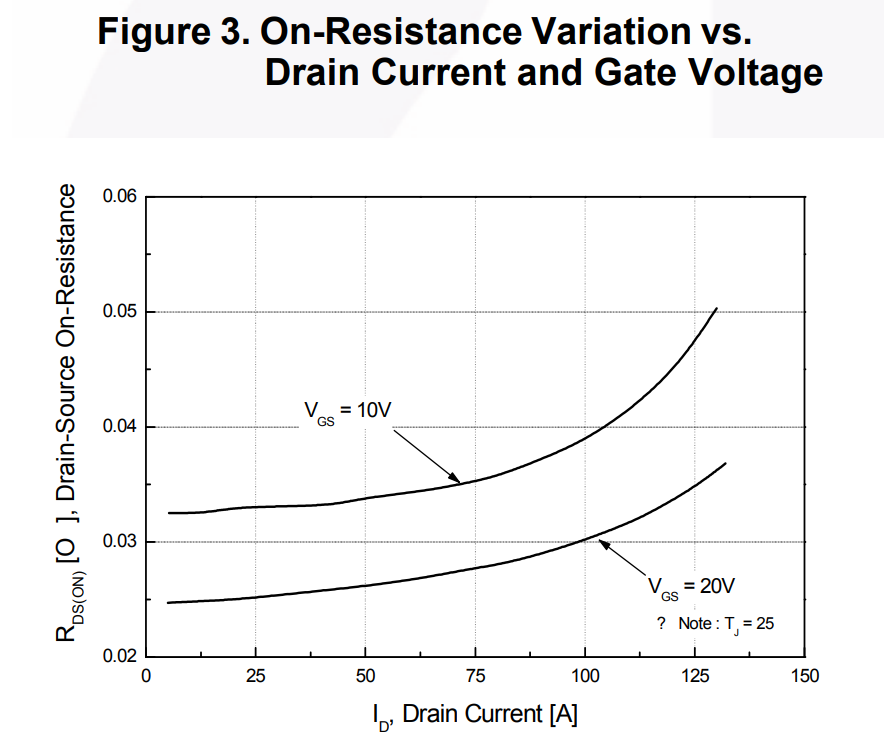

To get an average per switching period, we can use $\langle P_{Ts} \rangle = i_{rms}^2R_{DS(ON)}$ to give us a power value.

In [40]:
R_DSON = 0.0325 * units.ohm
D = 0.3 # Duty cycle
ipk = 5.4 * units.amp
irms = np.sqrt(D/3) * ipk

P_SC_CD = ipk**2 * R_DSON
print(f"The conduction losses from the semiconductor are about {P_SC_CD.to('watt')}.")

The conduction losses from the semiconductor are about 0.9477000000000001 W.


##### Switching
We can use the current through the MOSFET times the voltage from drain to source to get instantaneous power loss. If we integrate this quantity over a switching period, we can get the energy lost per period. It then can be normalized to be average power loss over switching period.

0.0001123815706666669 J


/tmp/ipykernel_601581/2949928057.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


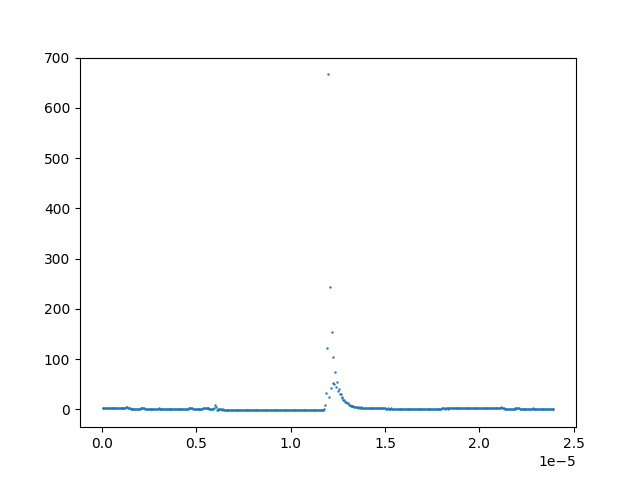

In [55]:
data = pd.read_csv("../lab7/data/baseline_full.csv")
increment = float(data["Increment"][0])
data = data.iloc[1: , :]
data = data.astype(float)

time = data["X"].to_numpy() * increment
ipk = data["CH1"].to_numpy() * 20
vds = data["CH2"].to_numpy()

n_bins = 500 # choose how many samples to use 
bin_size = (max(time) - min(time))/n_bins
time_res, vds_res, ipk_res = [],[], []
# Resample the data with consistent density 
for i in range(n_bins-1): 
    lower = time >= min(time)+i*bin_size
    higher = time < min(time)+(i+1)*bin_size
    time_res.append(np.mean(time[np.where(lower & higher)]))
    vds_res.append(np.mean(vds[np.where(lower & higher)]))
    ipk_res.append(np.mean(np.abs(ipk[np.where(lower & higher)])))

p = np.multiply(ipk, vds)
p_res = np.multiply(ipk_res, vds_res)
e = np.trapz(p, time)
e_res = np.trapz(p_res, time_res) * units.joule

fig, ax = plt.subplots()  
ax.scatter(time_res, p_res, s=0.5)
print(e_res)


fs = 50e3 / units.second
Ts = 1/fs
P_SC_SW = e_res / Ts

### Transformer
##### Conduction Losses
I am unsure if conduction losses on both sides matter? Probably?
$\langle P_{Ts} \rangle = i_{rms}^2R$
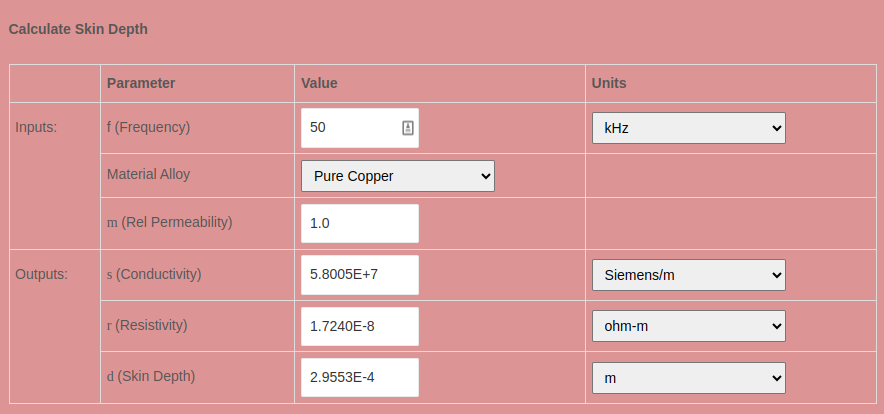
The skin is less than our material with given parameters, so we know the resistivity from the calculator.

In [45]:
R = 1.724e-8 * units.ohm / units.meter
mean_turn_length = 33 * units.mm
a = 0.731

n_primary = 8
n_secondary = 7
irms_primary = irms
irms_secondary = irms / a

loss_primary = (irms_primary**2 * R *  n_primary * mean_turn_length).to('watt').to_compact()
loss_secondary = (irms_secondary**2 * R * n_secondary * mean_turn_length).to('watt').to_compact()
P_TR_CD = loss_primary + loss_secondary

print(f"The transformer conduction loss is {P_TR_CD} with {loss_primary} being from the primary winding and {loss_secondary} being from the secondary.")


The transformer conduction loss is 35.00388138969603 nW with 13.271765760000003 nW being from the primary winding and 21.732115629696032 nW being from the secondary.


##### Eddy Current Conduction Losses
These are negligible due to our ferrite material and low frequencies.
##### Hysteretic Losses
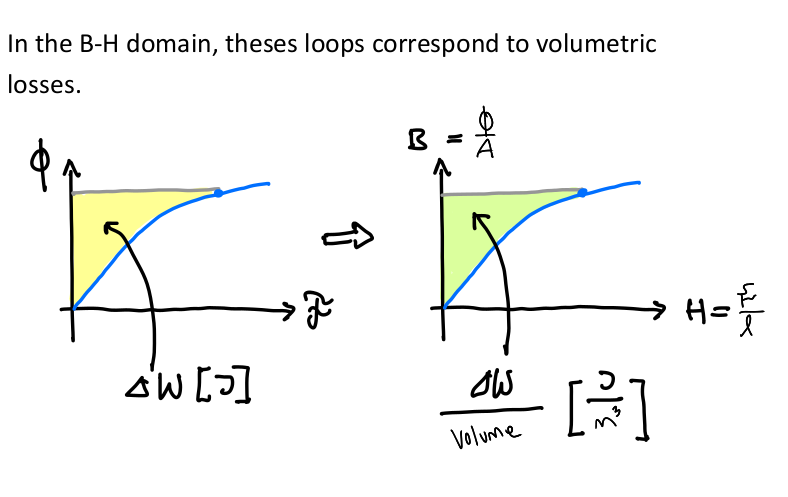

### RC Snubber
??? confused on this one
Baseline vs damped

### RCD Clamp
##### Resistor Losses
$\langle P_{Ts} \rangle = \frac{i_{pk}^2}{2T_s} \frac{L}{1-\frac{V}{Vcp}}$

In [67]:
L = 0.26e-6 * units.farad
Vcp = 49.8 * units.volt
V = 8.08 * units.volt
ipk = 5.4 * units.amp
test = 1 * units.watt
P_RCD_R = ipk**2/(2*Ts) * L * 1/(1-(V/Vcp))
print(P_RCD_R.to_base_units())
print(test.to_base_units())

0.22624860977948225 A⁴·s³/kg/m²
1.0 kg·m²/s³


##### Diode Losses

([<matplotlib.patches.Wedge at 0x7fe6cca38bb0>,
 [Text(1.0972104619519156, 0.07828922137346908, 'SC: Conduction'),
  Text(0.929157656770227, 0.5887835331131989, 'SC: Switching'),
  Text(-0.9774284251272903, -0.504612399523818, 'TR: Conduction'),
  Text(1.0998409491956964, -0.018705252532638945, 'RCD: R'),
  Text(1.1, -6.436839508821047e-09, 'RC Snubber')])

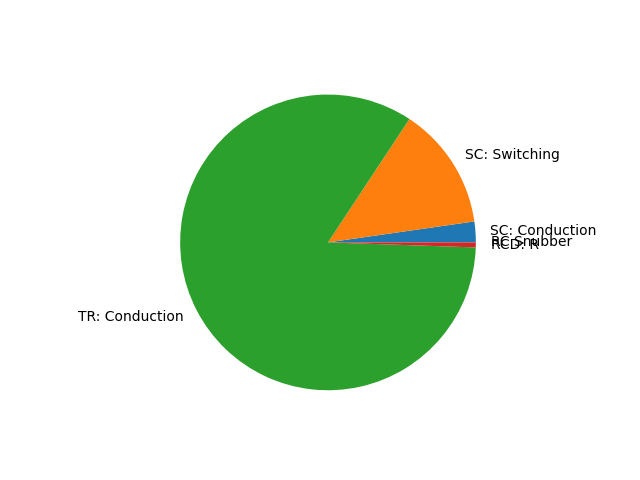

In [70]:
total = (P_SC_CD + P_SC_SW + P_TR_CD).magnitude + P_RCD_R.magnitude
labels = 'SC: Conduction', 'SC: Switching', 'TR: Conduction', 'RCD: R', 'RC Snubber'
sizes = [P_SC_CD.magnitude/total * 100,
         P_SC_SW.magnitude/total * 100,
         P_TR_CD.magnitude/total * 100,
         P_RCD_R.magnitude/total * 100, 0]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)